# Noise-contrastive estimation

See http://proceedings.mlr.press/v9/gutmann10a/gutmann10a.pdf or [Deep Learning](https://www.deeplearningbook.org/) section 18.6 for details. The following simple example estimates mean (`mu`), standard deviation (`sigma`) and normalization constant (`Z`) of a squared exponential model via noise-contrastive estimation.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

## Dataset

In [2]:
n = 300

# Parameters of unknown data distribution
mu = 3.2
sigma = 1.9

# Samples from unknown data distribution
x1 = torch.randn((n,)) * sigma + mu
y1 = torch.ones_like(x1)

# Noise distribution (can also be uniform or something else ...)
noise_dist = torch.distributions.Normal(x1.mean(), x1.std() * 2)

# Samples from noise distribution
x2 = noise_dist.rsample(x1.shape)
y2 = torch.zeros_like(x2)

# Training dataset
x = torch.cat([x1, x2])
y = torch.cat([y1, y2])

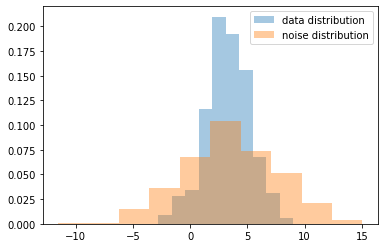

In [3]:
density = True

plt.hist(x1.numpy(), alpha=0.4, density=density, label='data distribution')
plt.hist(x2.numpy(), alpha=0.4, density=density, label='noise distribution')
plt.legend();

## Training

In [4]:
class Model(nn.Module):
    """
    Squared exponential model.
    
    Parameters are estimated by contrasting training data 
    (from an unknown data distribution) to data from a noise 
    distribution in context of a binary classification task. 
    The model learns to predict the probability that input x 
    belongs to the data distribution.
    """
    def __init__(self, noise_dist, m_0=1.0, s_0=1.0, c_0=1.0):
        super().__init__()        
        # Mean
        self.m = nn.Parameter(torch.tensor(m_0))
        # standard deviation
        self.s = nn.Parameter(torch.tensor(s_0))
        # log normalization constant
        self.c = nn.Parameter(torch.tensor(c_0))
        # noise 
        self.noise_dist = noise_dist
        
    def forward(self, x):
        energy = 0.5 / self.s ** 2 * (x - self.m) ** 2
                
        # model log probability
        log_p_model_x = -energy  + self.c
        # noise log probability
        log_p_noise_x = self.noise_dist.log_prob(x)
                
        return torch.sigmoid(log_p_model_x - log_p_noise_x)

In [5]:
ds = TensorDataset(x, y)
dl = DataLoader(ds, batch_size=10, shuffle=True)

In [6]:
model = Model(noise_dist)
loss_func = nn.BCELoss()
opt = optim.SGD(model.parameters(), lr=1e-2)

In [7]:
for epoch in range(1, 101):
    for x_batch, y_batch, in dl:
        y_pred = model(x_batch)
        
        loss = loss_func(y_pred, y_batch)        
        loss.backward()
        
        opt.step()
        opt.zero_grad()

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = loss_func(model(x), y)
            print(f'Loss in epoch {epoch} = {loss:.2f}')

Loss in epoch 10 = 0.81
Loss in epoch 20 = 0.67
Loss in epoch 30 = 0.62
Loss in epoch 40 = 0.60
Loss in epoch 50 = 0.60
Loss in epoch 60 = 0.59
Loss in epoch 70 = 0.59
Loss in epoch 80 = 0.59
Loss in epoch 90 = 0.59
Loss in epoch 100 = 0.59


## Results

In [8]:
# estimated mean, true mean
model.m.item(), mu

(3.199166774749756, 3.2)

In [9]:
# estimated sigma, true sigma
model.s.item(), sigma

(1.9766186475753784, 1.9)

In [10]:
# estimated Z, true Z
np.exp(-model.c.item()), 1 / np.sqrt(1 / (2 * np.pi * sigma ** 2)) 

(4.781052868295946, 4.7625937217989005)

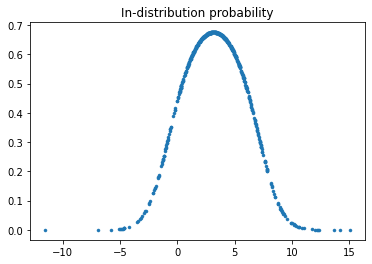

In [11]:
with torch.no_grad():
    y_pred = model(x)
    
plt.scatter(x, y_pred, marker='.', lw=0.5)
plt.title('In-distribution probability');